# Analyzing the impact of Political and Economic Sentiment on Healthcare and Tech stock market Performance in Election Year 2024

## By: Dennis Goldenberg, Kevin Shao, and Samaa Nadkarni

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date

# Reading in the Data

In [60]:
(date(year = 2024, month = 12, day = 6) - date(year = 2024, month = 12, day = 2)).days

4

In [86]:
#trump's odds
trump_odds = pd.read_csv("data/Trump_implied_prob_victory_odds.csv")
trump_odds["DATE"] = trump_odds["Date (UTC)"].apply(lambda x: datetime.strptime(x,
                                                          '%m-%d-%Y 00:00').date())
trump_odds.drop(columns = ["Date (UTC)","Timestamp (UTC)"], inplace = True)
trump_odds.rename({"Price": "trump_odds"}, axis = 1,inplace = True)

#t-bills 2 Year
tbills_2Y = pd.read_csv("data/Tbills_2Y_mkt_yield.csv")
tbills_2Y['DATE'] = tbills_2Y['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#tbills_2Y['DGS2'] = tbills_2Y['DGS2'].astype(float)

#t-bills 10 Year
tbills_10Y = pd.read_csv("data/Tbills_10Y_mkt_yield.csv")
tbills_10Y['DATE'] = tbills_10Y['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#tbills_10Y['DGS10'] = tbills_2Y['DGS10'].astype(float)

#Other Project Data
other_data = pd.read_csv("data/Project Data V1.csv")
other_data["DATE"] = other_data["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
other_data.drop(columns = ['date', 'Gold_Price', 'Oil_Price','Dollar_Index','Gold_Volume',
                           'Oil_Volume', 'BEIR'], inplace = True)

#Continue merging procedure
result_Frame = pd.merge(left = pd.merge(left = pd.merge(left = tbills_2Y, 
                                         right = tbills_10Y, 
                                         on = 'DATE'),
                right = trump_odds,
                on = 'DATE'),
         right = other_data,
         on = 'DATE')

In [87]:
columns = np.append(result_Frame.columns.values[-7], 
          np.append(result_Frame.columns.values[-3:-1],
          np.append(result_Frame.columns.values[-6:-3],
                    result_Frame.columns.values[-1])))
raw_data = result_Frame.copy()[columns]

## Linearly interpolating to fill in missing gaps on market yield Time Series

In [85]:
def interp(dates, array_vals):
    ret_vec = np.empty(shape = (len(array_vals)))
    for i in range(len(array_vals)):
        if array_vals[i] == '.':
            if i == 0:
                delta_0 = (dates[i + 1] - dates[i]).days
                delta_1 = (dates[i + 2] - dates[i + 1]).days
                ret_vec[i] = float(array_vals[i + 1]) - (delta_0/delta_1)(float(array_vals[i + 2]) - float(array_vals[i + 1]))
            elif i == len(array_vals) - 1:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i - 1] - dates[i - 2]).days
                ret_vec[i] = float(array_vals[i - 1]) + (delta_0/delta_1)(float(array_vals[i - 1]) - float(array_vals[i - 2]))
            else:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i + 1] - dates[i - 1]).days
                ret_vec[i] = (delta_0/delta_1)*float(array_vals[i - 1]) + (1 - delta_0/delta_1)*float(array_vals[i + 1])
        else:
            ret_vec[i] = array_vals[i]
    return ret_vec.astype(float)

In [89]:
raw_data['DGS2'] = interp(raw_data['DATE'], raw_data['DGS2'])
raw_data['DGS10'] = interp(raw_data['DATE'], raw_data['DGS10'])

In [93]:
raw_data[raw_data.columns.values[1:]].corr()

,NASDAQ 100 Tech Index,S&P Healthcare Index,DGS2,DGS10,trump_odds,VIX index
NASDAQ 100 Tech Index,1.000000,0.269505,0.113331,0.137348,0.578086,-0.327581
S&P Healthcare Index,0.269505,1.000000,-0.781413,-0.724043,0.182827,0.402273
DGS2,0.113331,-0.781413,1.000000,0.920299,-0.034817,-0.541470
DGS10,0.137348,-0.724043,0.920299,1.000000,0.032334,-0.359944
trump_odds,0.578086,0.182827,-0.034817,0.032334,1.000000,0.012486
VIX index,-0.327581,0.402273,-0.541470,-0.359944,0.012486,1.000000


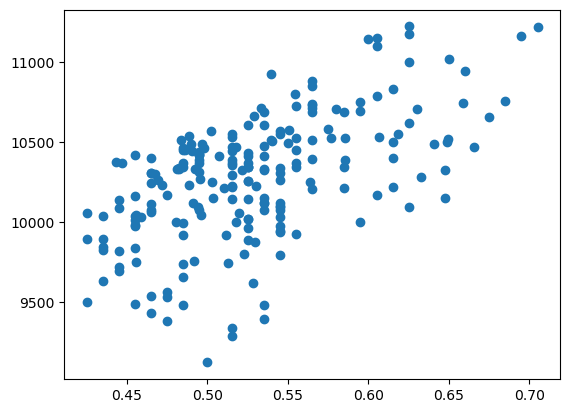

In [94]:
plt.scatter(raw_data['trump_odds'], raw_data['NASDAQ 100 Tech Index'])
plt.show()

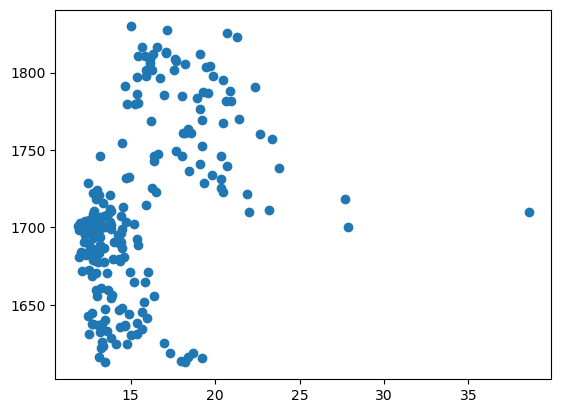

In [95]:
plt.scatter(raw_data['VIX index'], raw_data['S&P Healthcare Index'])
plt.show()

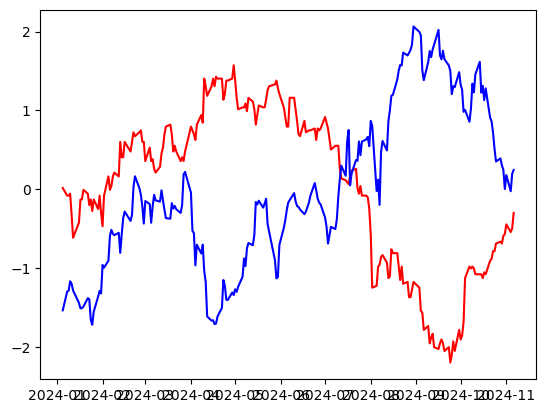

In [ ]:
plt.plot(raw_data['DATE'], 
         (raw_data['DGS2'] - np.mean(raw_data['DGS2']))/np.std(raw_data['DGS2']),
          color = 'red')
plt.plot(raw_data['DATE'], 
         (raw_data['S&P Healthcare Index'] - np.mean(raw_data['S&P Healthcare Index']))/np.std(raw_data['S&P Healthcare Index']),
          color = 'blue')
plt.show()